In [1]:
import time
import dateparser
import pytz
import json
import pandas as pd
import datetime
from datetime import datetime
from binance.client import Client

In [2]:
def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds

    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"

    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/

    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    # get epoch value in UTC
    epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)


def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms


def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance

    See dateparse docs for valid start and end string formats http://dateparser.readthedocs.io/en/latest/

    If using offset strings for dates add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"

    :param symbol: Name of symbol pair e.g BNBBTC
    :type symbol: str
    :param interval: Biannce Kline interval
    :type interval: str
    :param start_str: Start date string in UTC format
    :type start_str: str
    :param end_str: optional - end date string in UTC format
    :type end_str: str

    :return: list of OHLCV values

    """
    # create the Binance client, no need for api key
    client = Client("MYgUFxFMjeVglbzUsips2x38QR11XNJQ5NuYVbov3QBITOcyYmnBGA3MtuHTegWY", "tOfsgUFcmjb1odifv2F1z4gYjl8Fvbzr5xjbQmiMbNSZnADjRcpCuToHp1H0R2x7")

    # init our list
    output_data = []

    # setup the max limit
    limit = 500

    # convert interval to useful value in seconds
    timeframe = interval_to_milliseconds(interval)

    # convert our date strings to milliseconds
    start_ts = date_to_milliseconds(start_str)

    # if an end time was passed convert it
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    idx = 0
    # it can be difficult to know when a symbol was listed on Binance so allow start time to be before list date
    symbol_existed = False
    while True:
        # fetch the klines from start_ts up to max 500 entries or the end_ts if set
        temp_data = client.get_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            startTime=start_ts,
            endTime=end_ts
        )

        # handle the case where our start date is before the symbol pair listed on Binance
        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            # append this loops data to our output data
            output_data += temp_data

            # update our start timestamp using the last value in the array and add the interval timeframe
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            # it wasn't listed yet, increment our start date
            start_ts += timeframe

        idx += 1
        # check if we received less than the required limit and exit the loop
        if len(temp_data) < limit:
            # exit the while loop
            break

        # sleep after every 3rd call to be kind to the API
        if idx % 3 == 0:
            time.sleep(1)

    return output_data

def time_trans(t):
    # transform date type
    return datetime.fromtimestamp(int(str(t)[:10])).strftime('%Y-%m-%d %H:%M:%S')

KLINE_INTERVAL_12HOUR= '12h'</br>
KLINE_INTERVAL_15MINUTE= '15m'</br>
KLINE_INTERVAL_1DAY= '1d'</br>
KLINE_INTERVAL_1HOUR= '1h'</br>
KLINE_INTERVAL_1MINUTE= '1m'</br>
KLINE_INTERVAL_1MONTH= '1M'</br>
KLINE_INTERVAL_1WEEK= '1w'</br>
KLINE_INTERVAL_2HOUR= '2h'</br>
KLINE_INTERVAL_30MINUTE= '30m'</br>
KLINE_INTERVAL_3DAY= '3d'</br>
KLINE_INTERVAL_3MINUTE= '3m'</br>
KLINE_INTERVAL_4HOUR= '4h'</br>
KLINE_INTERVAL_5MINUTE= '5m'</br>
KLINE_INTERVAL_6HOUR= '6h'</br>
KLINE_INTERVAL_8HOUR= '8h'

In [3]:
symbol = "ETHUSDT"
start = "1 Nov, 2023"
end = "15 Nov, 2023"
interval = Client.KLINE_INTERVAL_1MINUTE

klines = get_historical_klines(symbol, interval, start, end)

# open a file with filename including symbol, interval and start and end converted to milliseconds
with open(
    "Binance_{}_{}_{}-{}.json".format(
        symbol,
        interval,
        date_to_milliseconds(start),
        date_to_milliseconds(end)
    ),
    'w'  # set file write mode
) as f:
    f.write(json.dumps(klines))

1499040000000,      # Open time</br>
"0.01634790",       # Open</br>
"0.80000000",       # High</br>
"0.01575800",       # Low</br>
"0.01577100",       # Close</br>
"148976.11427815",  # Volume</br>
1499644799999,      # Close time</br>
"2434.19055334",    # Quote asset volume</br>
308,                # Number of trades</br>
"1756.87402397",    # Taker buy base asset volume</br>
"28.46694368",      # Taker buy quote asset volume</br>
"17928899.62484339" # Can be ignored

In [4]:
df = pd.DataFrame(klines)

# assign columns name
df.columns = ['Open time',
            'Open',
            'High',
            'Low',
            'Close',
            'Volume',
            'Close time',
            'Quote asset volume',
            'Number of trades',
            'Taker buy base asset volume',
            'Taker buy quote asset volume',
            'Can be ignored'
            ]

# transform date type
df['Open time'] = df['Open time'].apply(time_trans)
df['Close time'] = df['Close time'].apply(time_trans)

# transform numeric type
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)

In [5]:
df

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
0,2023-11-01 08:00:00,1814.67,1815.10,1814.57,1815.10,168.97430000,2023-11-01 08:00:59,306653.98370600,400,125.63200000,227993.54080500,0
1,2023-11-01 08:01:00,1815.10,1815.38,1812.30,1812.30,273.60090000,2023-11-01 08:01:59,496328.68403200,698,57.97200000,105199.83442500,0
2,2023-11-01 08:02:00,1812.31,1813.86,1812.30,1813.86,129.61430000,2023-11-01 08:02:59,234982.44497400,496,78.10950000,141595.71174900,0
3,2023-11-01 08:03:00,1813.86,1813.86,1812.50,1812.98,119.44070000,2023-11-01 08:03:59,216566.92136000,423,39.76790000,72119.48808400,0
4,2023-11-01 08:04:00,1812.98,1813.01,1811.84,1813.00,98.17620000,2023-11-01 08:04:59,177946.05047900,486,42.03710000,76181.88588900,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20143,2023-11-15 07:43:00,1982.47,1982.48,1981.34,1981.99,62.65730000,2023-11-15 07:43:59,124168.26939900,204,32.26220000,63931.48566400,0
20144,2023-11-15 07:44:00,1982.00,1982.57,1981.09,1981.09,138.96570000,2023-11-15 07:44:59,275433.54572200,286,50.41150000,99915.25704400,0
20145,2023-11-15 07:45:00,1981.09,1981.10,1979.83,1979.84,204.96840000,2023-11-15 07:45:59,405963.96802700,467,53.90190000,106762.34633800,0
20146,2023-11-15 07:46:00,1979.83,1982.75,1979.83,1982.61,270.38710000,2023-11-15 07:46:59,535712.57733300,376,138.78840000,274962.94178400,0


<AxesSubplot:xlabel='Open time'>

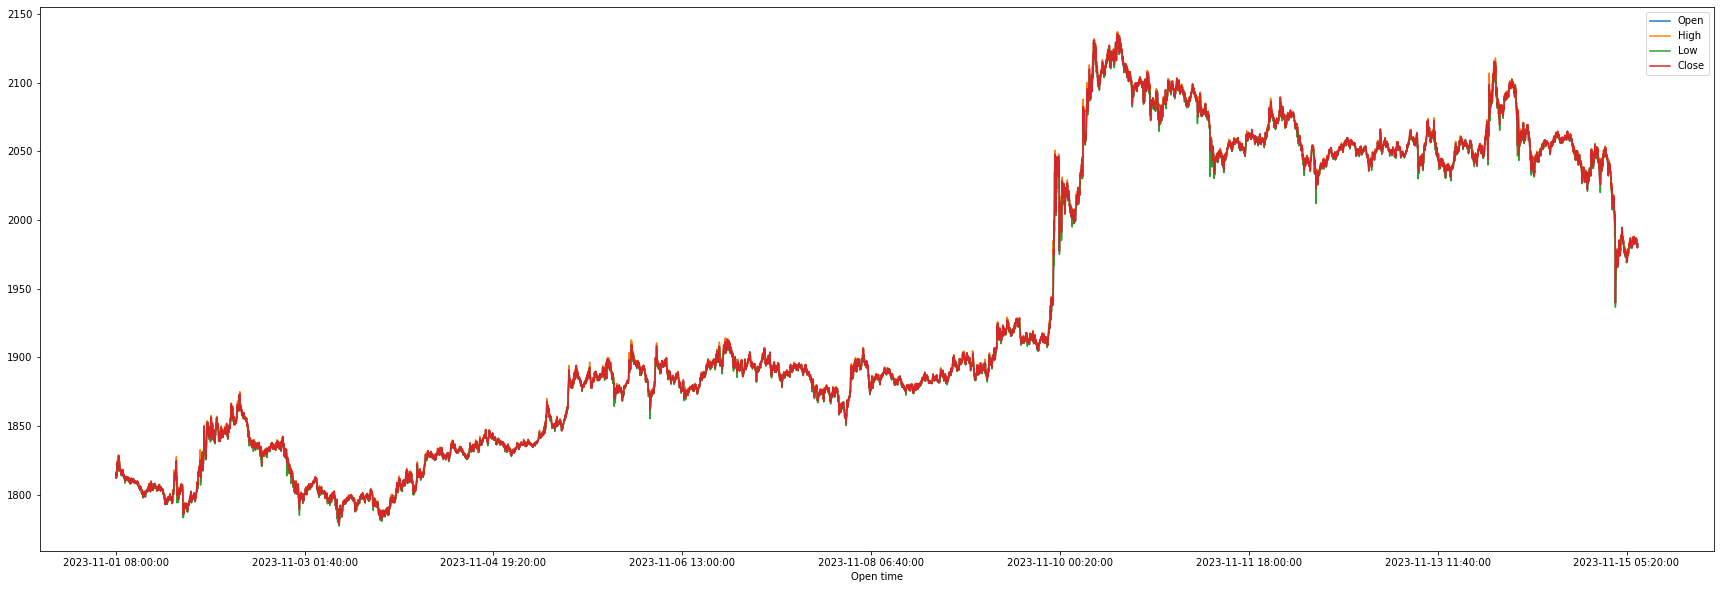

In [6]:
df.plot(x="Open time", y=['Open','High','Low','Close'],
        kind="line", figsize=(30, 10))